This notebook is dedicated to explore if there is a correlation of the tilt parameter from the pre-fit of the bkg runs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from gammapy.data import DataStore

import warnings
warnings.filterwarnings('ignore')

In [2]:
hesseras = ['hess1', 'hess2']

In [3]:
files = []
for hessera in hesseras:
    if hessera == 'hess1':
        idx_max = 37
    elif hessera == 'hess2':
        idx_max = 7
    for idx in range(idx_max):
        if idx==0:
            file = np.loadtxt(f'../results/norm_tilt_{hessera}_part{idx}.txt')
        else:
            file = np.concatenate((file, np.loadtxt(f'../results/norm_tilt_{hessera}_part{idx}.txt')))
    files.append(file)

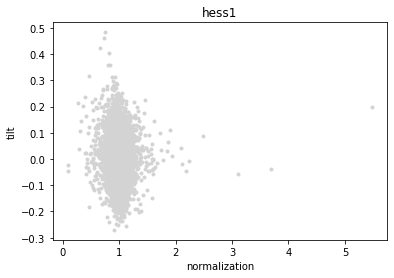

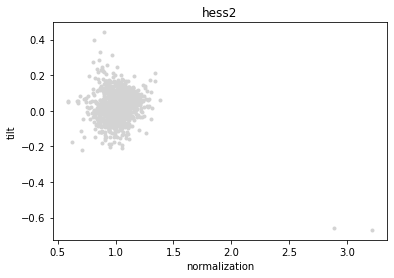

In [4]:
for i, hessera in enumerate(hesseras):
    plt.scatter(files[i][:, 1], files[i][:, 2], marker= '.', color='lightgray')
    plt.title(hessera)
    plt.xlabel('normalization')
    plt.ylabel('tilt')   
    plt.show()

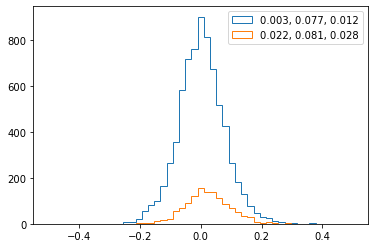

In [5]:
for i, hessera in enumerate(hesseras):
    d=files[i][:, 2]
    plt.hist(d, histtype='step', bins=np.linspace(-0.5, 0.5), label=f'{np.mean(d):.3f}, {np.std(d):.3f}, {1/np.sqrt(len(d)):.3f}')
plt.legend()

In [6]:
with open("../../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

tables= []
masks = []
for hessera in hesseras:
    runlist = np.loadtxt(f'../initial_runlist_{hessera}.txt')
    basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_zeta_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    masks.append([True if obsid in runlist else False for obsid in ds.obs_table['OBS_ID']])
    tables.append(ds.obs_table)

In [7]:
rm_columns = ['DATE-END', 'DATE-OBS','DEADC', 'TELLIST','TIME-END','TIME-OBS','TSTART','TSTOP', 'OBJECT','BKG_SCALE']

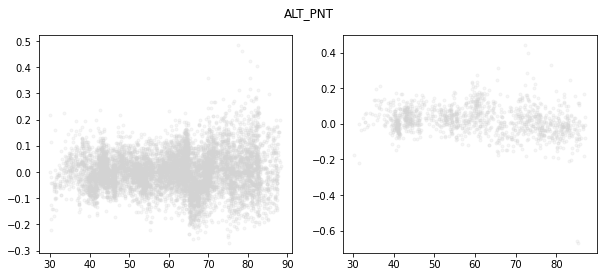

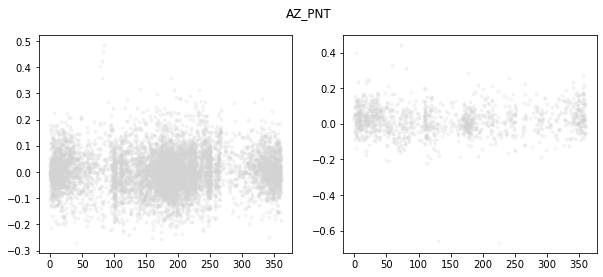

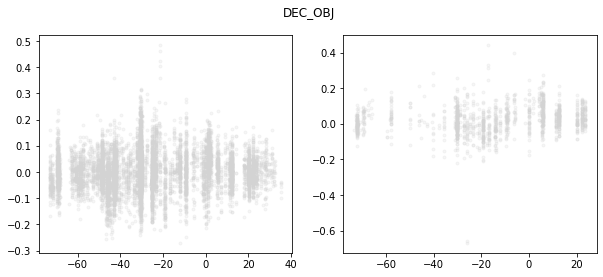

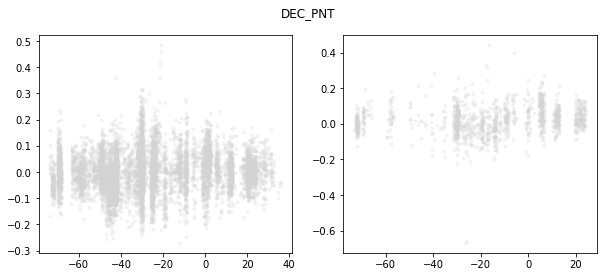

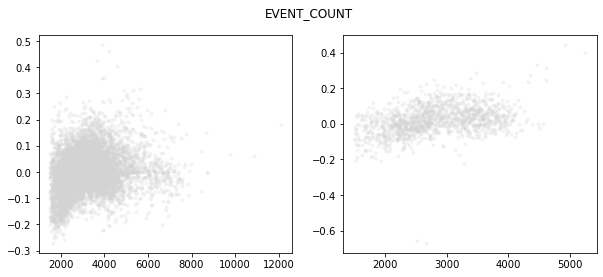

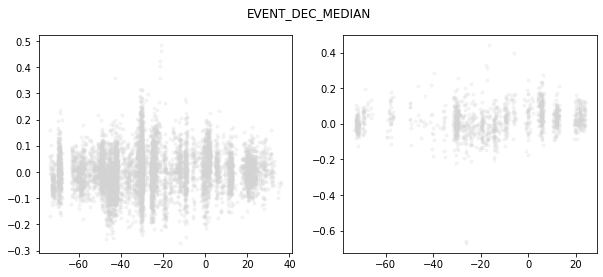

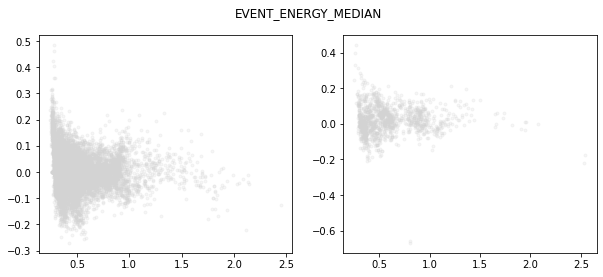

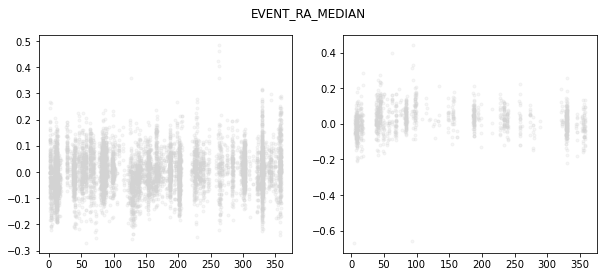

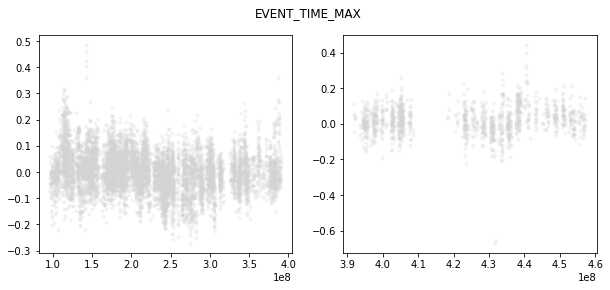

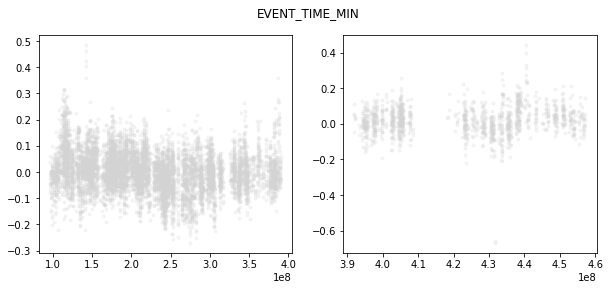

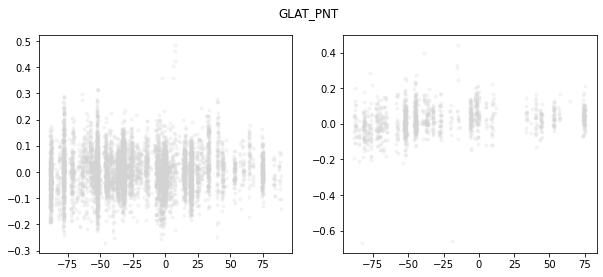

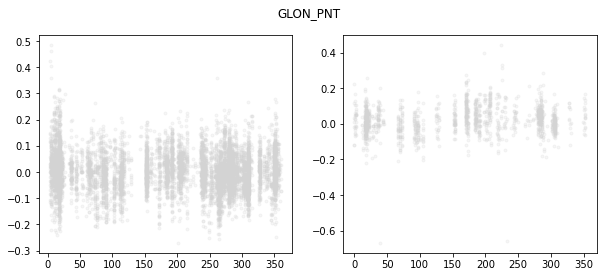

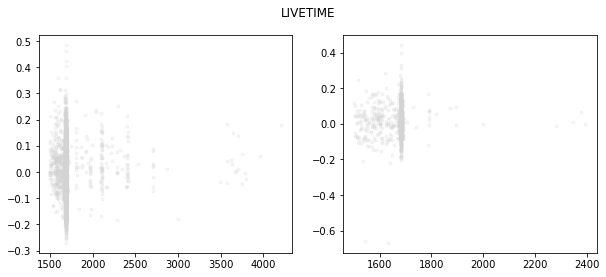

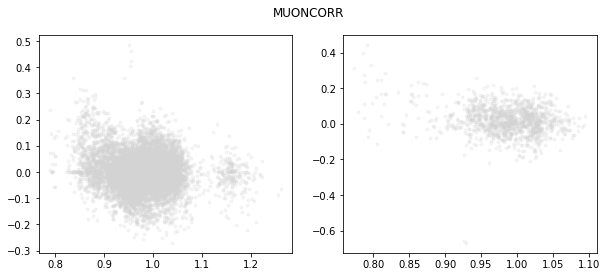

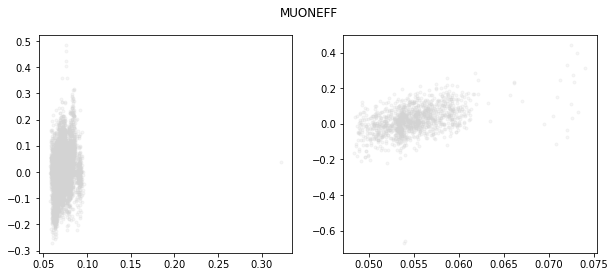

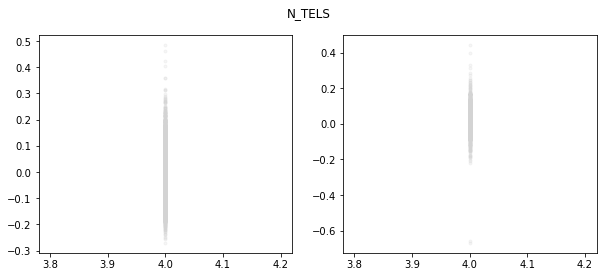

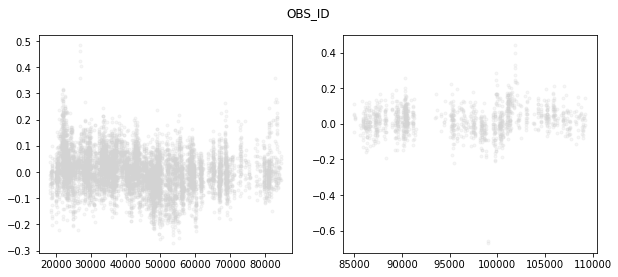

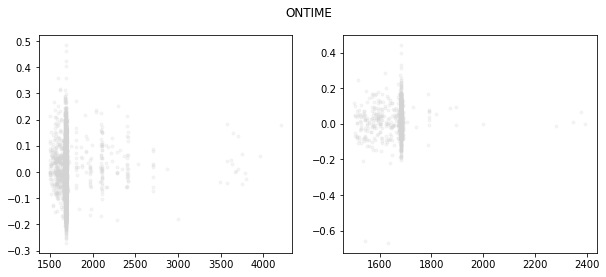

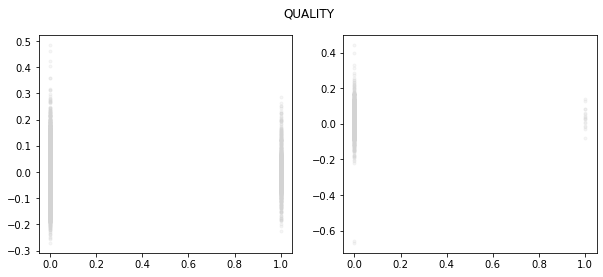

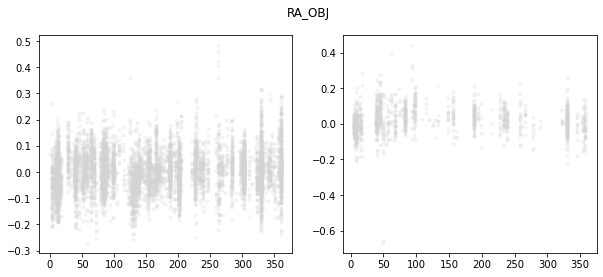

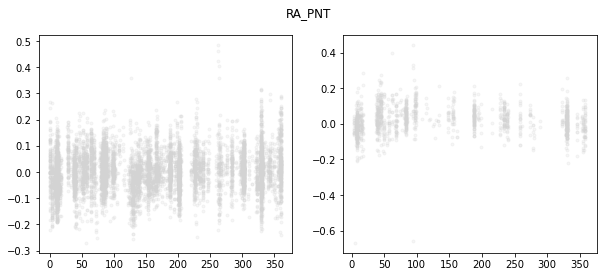

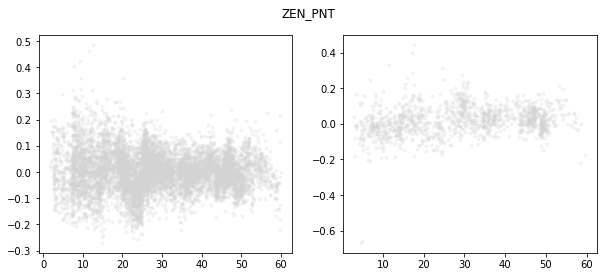

In [8]:
for par in tables[0].columns:
    if par not in rm_columns:
        fig, ax = plt.subplots(1,2, figsize=(10, 4))
        for i in range(2):
            ax[i].scatter(tables[i][par][masks[i]], files[i][:, 2], marker='.', alpha=0.2, color='lightgray')
        plt.suptitle(par)
        plt.show()

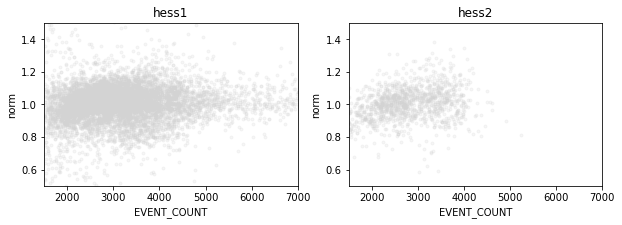

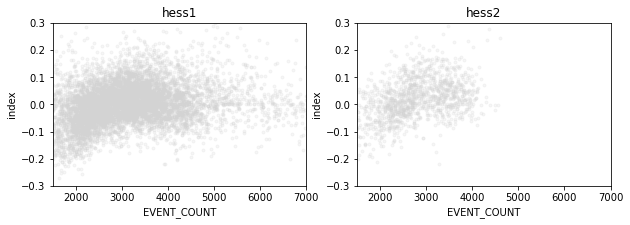

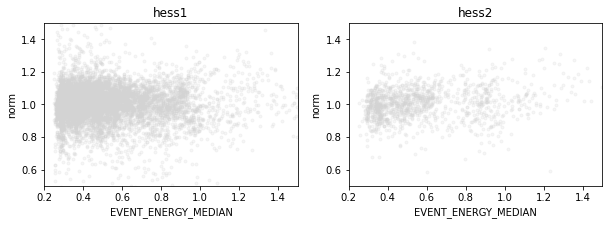

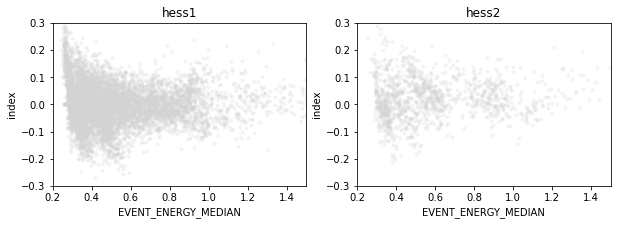

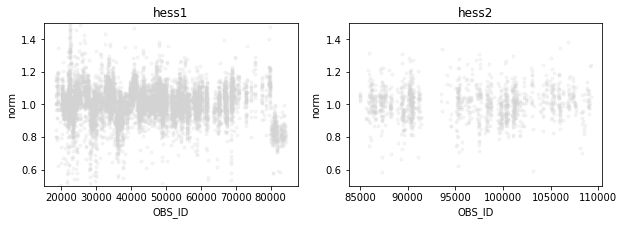

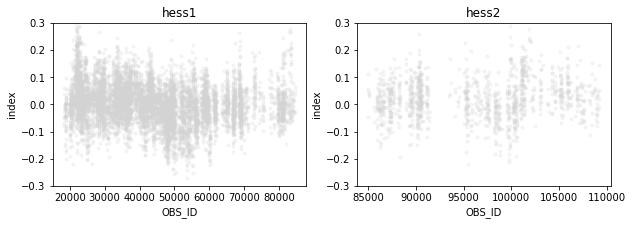

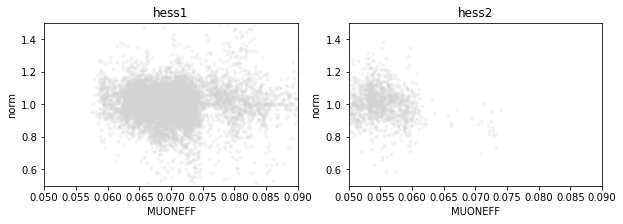

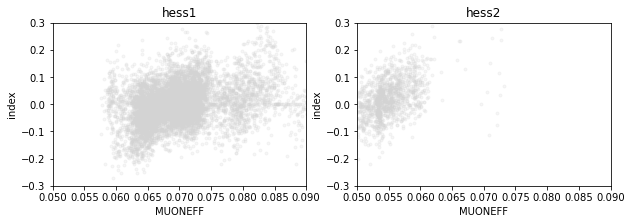

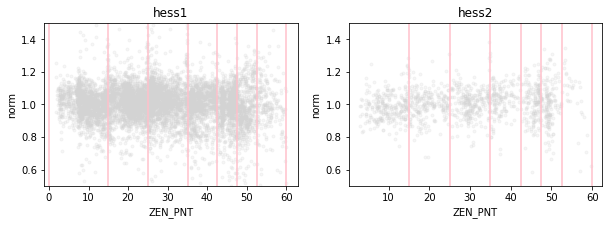

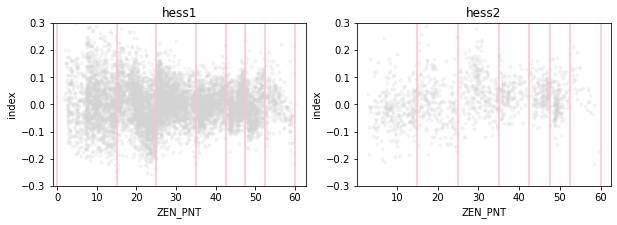

In [9]:
xlim = [(1500, 7000), (0.2, 1.5), None, (0.05, 0.09), None]
for j, par in enumerate(['EVENT_COUNT', 'EVENT_ENERGY_MEDIAN', 'OBS_ID', 'MUONEFF', 'ZEN_PNT']):
    fig, ax = plt.subplots(1,2, figsize=(10, 3))
    for i in range(2):
        ax[i].scatter(tables[i][par][masks[i]], files[i][:, 1], marker='.', alpha=0.2, color='lightgray')
        ax[i].set_xlim(xlim[j])
        ax[i].set_ylim(0.5, 1.5)
        ax[i].set_title(hesseras[i])
        ax[i].set_xlabel(par)
        ax[i].set_ylabel('norm')
        if par == 'ZEN_PNT':
            for zen in cfg['zen_bins']:
                ax[i].axvline(zen, color='pink')
    plt.show()    

    fig, ax = plt.subplots(1,2, figsize=(10, 3))
    for i in range(2):
        ax[i].scatter(tables[i][par][masks[i]], files[i][:, 2], marker='.', alpha=0.2, color='lightgray')
        ax[i].set_xlim(xlim[j])
        ax[i].set_ylim(-0.3, 0.3)
        ax[i].set_title(hesseras[i])
        ax[i].set_xlabel(par)
        ax[i].set_ylabel('index')
        if par == 'ZEN_PNT':
            for zen in cfg['zen_bins']:
                ax[i].axvline(zen, color='pink')
    plt.show()

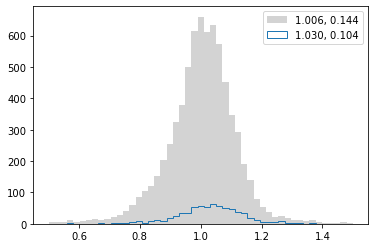

In [10]:
hessera = 'hess1'
i = 0

mask1 = files[i][:, 2] > 0.02
mask2 = tables[i][masks[i]]['MUONEFF'] < 0.068
mask_f = mask1 & mask2

bins = np.linspace(0.5, 1.5, 50)
d= files[i][:, 1]
plt.hist(d, color='lightgray', bins=bins, label=f'{np.mean(d):.3f}, {np.std(d):.3f}')
d=files[i][mask_f, 1]
plt.hist(d, histtype='step', bins=bins, label=f'{np.mean(d):.3f}, {np.std(d):.3f}')
plt.legend()

# fitting a correlaction to tilt values

In [12]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    y = a*x+b
    return y

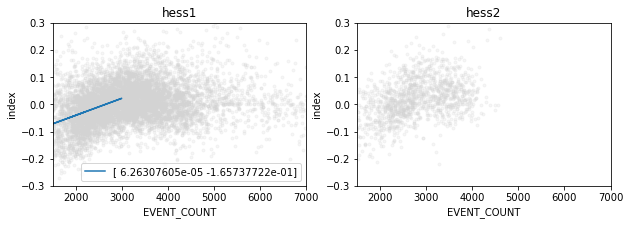

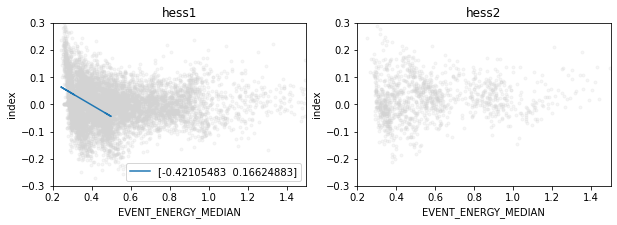

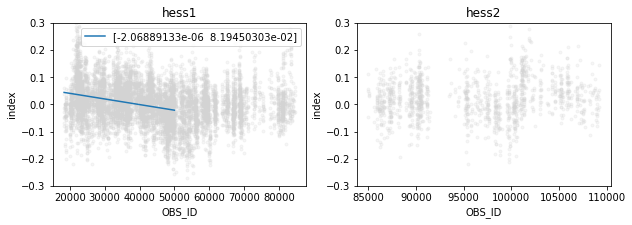

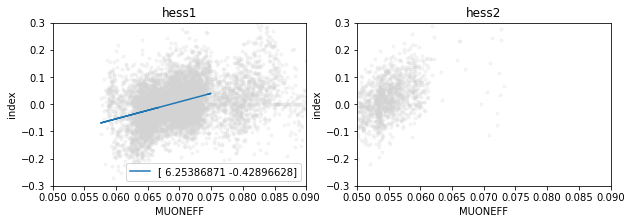

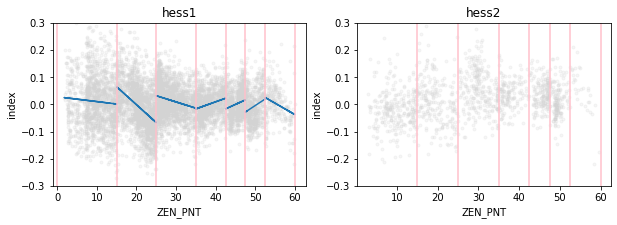

In [32]:
xlim = [(1500, 7000), (0.2, 1.5), None, (0.05, 0.09), None]
for j, par in enumerate(['EVENT_COUNT', 'EVENT_ENERGY_MEDIAN', 'OBS_ID', 'MUONEFF', 'ZEN_PNT']):

    fig, ax = plt.subplots(1,2, figsize=(10, 3))
    for i in range(2):
        ax[i].scatter(tables[i][par][masks[i]], files[i][:, 2], marker='.', alpha=0.2, color='lightgray')
        
        if i ==0:
            if par != 'ZEN_PNT':
                if par == 'EVENT_COUNT':
                    mask_par = tables[0][par][masks[0]] < 3000
                elif par == 'EVENT_ENERGY_MEDIAN': 
                    mask_par = tables[0][par][masks[0]] < 0.5
                elif par== 'OBS_ID':
                    mask_par = tables[0][par][masks[0]] < 50000
                elif par== 'MUONEFF':
                    mask_par = tables[0][par][masks[0]] < 0.075            
                para, cov = curve_fit(linear, (tables[0][par][masks[0]])[mask_par], (files[0][:, 2])[mask_par])
                ax[i].plot((tables[0][par][masks[0]])[mask_par], linear((tables[0][par][masks[0]])[mask_par], *para), color='C0', label=para)
                ax[i].legend()
            else:
                for z_idx in range(len(cfg['zen_bins'])-1):
                    m1 = tables[0][par][masks[0]] < cfg['zen_bins'][z_idx +1]  
                    m2= tables[0][par][masks[0]] > cfg['zen_bins'][z_idx]     
                    mask_par= m1&m2
                    para, cov = curve_fit(linear, (tables[0][par][masks[0]])[mask_par], (files[0][:, 2])[mask_par])
                    ax[i].plot((tables[0][par][masks[0]])[mask_par], linear((tables[0][par][masks[0]])[mask_par], *para), color='C0')
        ax[i].set_xlim(xlim[j])
        ax[i].set_ylim(-0.3, 0.3)
        ax[i].set_title(hesseras[i])
        ax[i].set_xlabel(par)
        ax[i].set_ylabel('index')
        if par == 'ZEN_PNT':
            for zen in cfg['zen_bins']:
                ax[i].axvline(zen, color='pink')
    plt.show()